In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
import joblib

In [2]:
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
print("All libraries imported successfully")
print(f"Random State: {RANDOM_STATE}")

All libraries imported successfully
Random State: 42


In [4]:
# Configuration
CLASSIFIER_PKL = r"E:\Loan Model\best_loan_model.pkl"
SCALER_PKL = r"E:\Loan Model\scaler.pkl"
HYBRID_PKL = r"E:\Loan Model\hybrid_pipeline.pkl"
EVAL_CSV = r"E:\Loan Model\Regression_Model_Evaluation_Summary.csv"
N_CLUSTERS = 3  
N_BINS = 5      
SHOW_PLOTS = True

# Columns
NUMERICAL_COLS = ['Age', 'Dependents', 'Annual_Income', 'Monthly_Income', 'Credit_Score', 
                  'Existing_Loans', 'Total_Existing_Loan_Amount', 'Loan_Amount_Requested', 
                  'Loan_Term', 'Bank_Account_History']
REG_NUM_COLS = ['Age', 'Dependents', 'Annual_Income', 'Monthly_Income', 'Credit_Score', 
                'Existing_Loans', 'Total_Existing_Loan_Amount', 'Loan_Term', 'Bank_Account_History']
CAT_COLS = ['Gender', 'Marital_Status', 'Education', 'Employment_Status', 'Residential_Status', 'Loan_Purpose']
TARGET_CLASS = 'Loan_Approval_Status'
TARGET_REG = 'Loan_Amount_Requested'

# Encoders for categorical variables
ENCODERS = {
    'Gender': {'Male': 0, 'Female': 1},
    'Marital_Status': {'Married': 0, 'Single': 1, 'Divorced': 2},
    'Education': {'High School': 0, 'Graduate': 1, 'Postgraduate': 2},
    'Employment_Status': {'Unemployed': 0, 'Employed': 1, 'Self-Employed': 2},
    'Residential_Status': {'Own': 1, 'Rent': 0, 'Other': 2},
    'Loan_Purpose': {'Agriculture': 0, 'Equipment Purchase': 1, 'Small Business Start-up': 2, 'Working Capital': 3}
}

# Parameter grids for classifiers
PARAM_GRIDS = {
    'Decision Tree': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]},
    'XGBoost': {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]},
    'CatBoost': {'iterations': [100, 200], 'depth': [4, 6, 8], 'learning_rate': [0.01, 0.1]},
    'LightGBM': {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]}
}

print("Configuration loaded")
print(f"Number of clusters: {N_CLUSTERS}")
print(f"Number of bins for regression: {N_BINS}")
print(f"Numerical columns: {len(NUMERICAL_COLS)}")
print(f"Categorical columns: {len(CAT_COLS)}")

Configuration loaded
Number of clusters: 3
Number of bins for regression: 5
Numerical columns: 10
Categorical columns: 6


In [5]:
def remove_outliers(df, cols):
    """Remove outliers using IQR method."""
    print(f"\nRemoving outliers for columns: {cols}")
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        print(f"{col}: Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}, Lower={lower_bound:.2f}, Upper={upper_bound:.2f}")
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

def eval_reg_with_bins(y_true, y_pred, n_bins=N_BINS, title=""):
    """Evaluate regression model with binned confusion matrix."""
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = (np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-6, None))) * 100.0)
    acc_pct = max(0.0, 100.0 - mape)

    # Build quantile bins
    try:
        edges = np.quantile(y_true, np.linspace(0, 1, n_bins + 1))
        edges = np.unique(edges)
        if len(edges) <= 2:
            edges = np.linspace(y_true.min(), y_true.max(), n_bins + 1)
    except Exception:
        edges = np.linspace(y_true.min(), y_true.max(), n_bins + 1)

    yb_true = pd.cut(y_true, bins=edges, labels=False, include_lowest=True)
    yb_pred = pd.cut(y_pred, bins=edges, labels=False, include_lowest=True)
    mask = (~pd.isna(yb_true)) & (~pd.isna(yb_pred))
    yb_true = yb_true[mask].astype(int)
    yb_pred = yb_pred[mask].astype(int)

    top1 = accuracy_score(yb_true, yb_pred)
    off1 = np.mean(np.abs(yb_true - yb_pred) <= 1)
    cm = confusion_matrix(yb_true, yb_pred, labels=list(range(len(edges)-1)))

    print(f"\n{title}Metrics:")
    print(f"R²: {r2:.3f}")
    print(f"MAE: {mae:,.1f}")
    print(f"RMSE: {rmse:,.1f}")
    print(f"MAPE: {mape:.1f}%")
    print(f"Accuracy: {acc_pct:.1f}%")
    print(f"Bin Accuracy (Top-1): {top1:.3f}")
    print(f"Bin Accuracy (±1): {off1:.3f}")

    if SHOW_PLOTS:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[f"B{i}" for i in range(cm.shape[1])],
                    yticklabels=[f"B{i}" for i in range(cm.shape[0])])
        plt.title(f"{title}Binned Confusion Matrix (n_bins={n_bins})")
        plt.xlabel("Predicted Bin")
        plt.ylabel("Actual Bin")
        plt.tight_layout()
        plt.show()

    return {"r2": float(r2), "mae": float(mae), "rmse": float(rmse), "mape": float(mape),
            "accuracy_pct": float(acc_pct), "bin_acc": float(top1), "bin_acc_pm1": float(off1), "cm": cm.tolist()}

print("Helper functions defined")

Helper functions defined


In [6]:
# Load data
try:
    train_df = pd.read_csv(r"E:\Loan Model\Loan_Dataset_train.csv")
    test_df = pd.read_csv(r"E:\Loan Model\Loan_Data_Test.csv")
except FileNotFoundError:
    print("Dataset files not found. Please check file paths or create sample data.")
    
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print()
print("Column names in training data:")
print(train_df.columns.tolist())

Training data shape: (52000, 18)
Test data shape: (10400, 17)

Column names in training data:
['Applicant_ID', 'Gender', 'Age', 'Marital_Status', 'Dependents', 'Education', 'Employment_Status', 'Residential_Status', 'Annual_Income', 'Monthly_Income', 'Credit_Score', 'Existing_Loans', 'Total_Existing_Loan_Amount', 'Loan_Amount_Requested', 'Loan_Term', 'Loan_Purpose', 'Bank_Account_History', 'Loan_Approval_Status']


In [7]:
def train_classifier(train_df, test_df):
    """Train and evaluate classification models."""
    print("Training data shape:", train_df.shape)
    print("Test data shape:", test_df.shape)
    print("\nTraining data info:")
    print(train_df.info())
    print("\nTest data info:")
    print(test_df.info())

    # Exploratory Data Analysis
    print("Exploratory Data Analysis")
    print("Statistical Summary of Numerical Columns:")
    print(train_df.describe())

    return train_df, test_df
train_df, test_df = train_classifier(train_df, test_df)

Training data shape: (52000, 18)
Test data shape: (10400, 17)

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52000 entries, 0 to 51999
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Applicant_ID                52000 non-null  int64  
 1   Gender                      52000 non-null  object 
 2   Age                         52000 non-null  int64  
 3   Marital_Status              52000 non-null  object 
 4   Dependents                  52000 non-null  int64  
 5   Education                   52000 non-null  object 
 6   Employment_Status           52000 non-null  object 
 7   Residential_Status          52000 non-null  object 
 8   Annual_Income               52000 non-null  float64
 9   Monthly_Income              52000 non-null  float64
 10  Credit_Score                52000 non-null  int64  
 11  Existing_Loans              52000 non-null  int64  
 12  Total

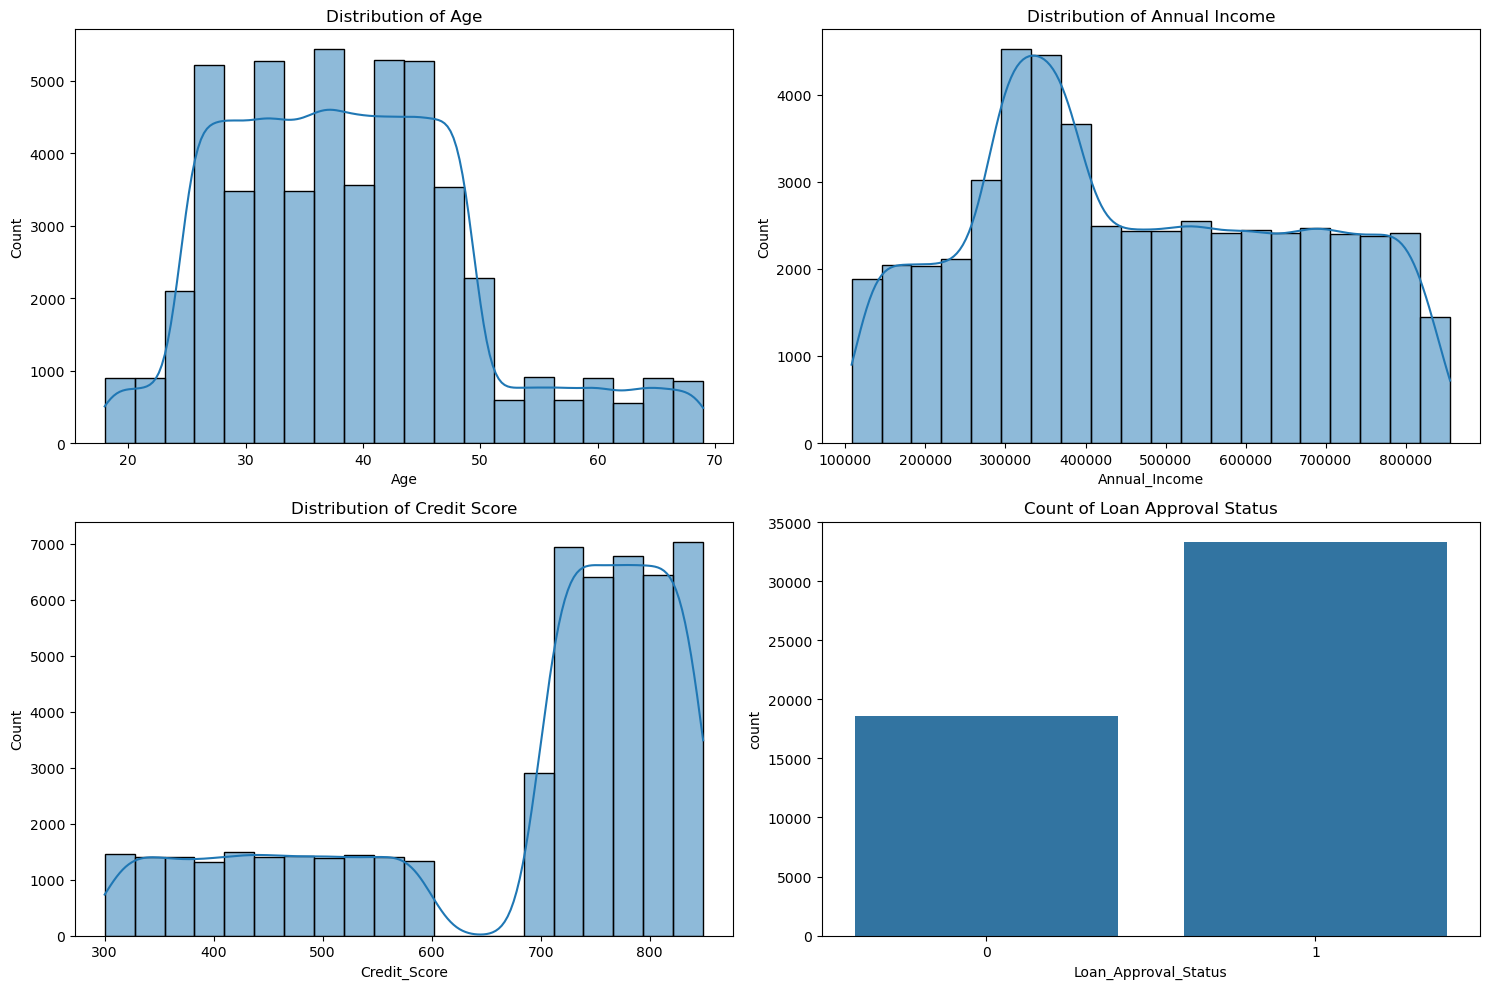

In [8]:
# Visualizations
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(data=train_df, x='Age', bins=20, kde=True)
plt.title('Distribution of Age')

plt.subplot(2, 2, 2)
sns.histplot(data=train_df, x='Annual_Income', bins=20, kde=True)
plt.title('Distribution of Annual Income')

plt.subplot(2, 2, 3)
sns.histplot(data=train_df, x='Credit_Score', bins=20, kde=True)
plt.title('Distribution of Credit Score')

plt.subplot(2, 2, 4)
sns.countplot(data=train_df, x='Loan_Approval_Status')
plt.title('Count of Loan Approval Status')
plt.tight_layout()
plt.show()

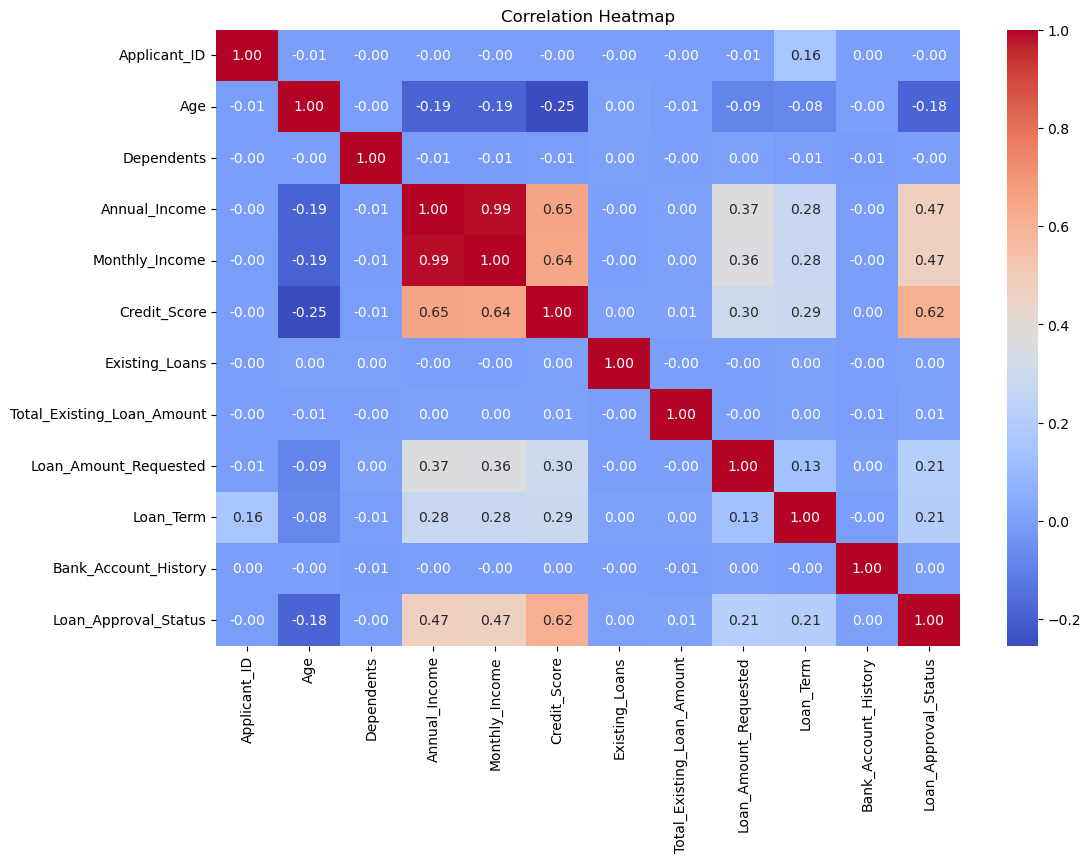

In [9]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
sns.heatmap(train_df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [10]:
# Encode categorical variables
print("Encoding categorical variables")
for col, mapping in ENCODERS.items():
    if col in train_df.columns:
        train_df[col] = train_df[col].map(mapping)
        print(f"Encoded {col}: {mapping}")
    if col in test_df.columns:
        test_df[col] = test_df[col].map(mapping)

# Remove outliers
print("Removing outliers from training data")
train_df_before_outlier = train_df.copy()
train_df = remove_outliers(train_df, NUMERICAL_COLS)
print("Training data shape after outlier removal:", train_df.shape)

# outlier bounds to test data
print("\nApplying outlier bounds to test data...")
bounds = {}
for col in NUMERICAL_COLS:
    if col in train_df.columns:
        Q1 = train_df[col].quantile(0.25)
        Q3 = train_df[col].quantile(0.75)
        IQR = Q3 - Q1
        bounds[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        print(f"{col}: Lower={bounds[col][0]:.2f}, Upper={bounds[col][1]:.2f}")

for col, (lower, upper) in bounds.items():
    if col in test_df.columns:
        test_df = test_df[(test_df[col] >= lower) & (test_df[col] <= upper)]
print("Test data shape after outlier removal:", test_df.shape)

Encoding categorical variables
Encoded Gender: {'Male': 0, 'Female': 1}
Encoded Marital_Status: {'Married': 0, 'Single': 1, 'Divorced': 2}
Encoded Education: {'High School': 0, 'Graduate': 1, 'Postgraduate': 2}
Encoded Employment_Status: {'Unemployed': 0, 'Employed': 1, 'Self-Employed': 2}
Encoded Residential_Status: {'Own': 1, 'Rent': 0, 'Other': 2}
Encoded Loan_Purpose: {'Agriculture': 0, 'Equipment Purchase': 1, 'Small Business Start-up': 2, 'Working Capital': 3}
Removing outliers from training data

Removing outliers for columns: ['Age', 'Dependents', 'Annual_Income', 'Monthly_Income', 'Credit_Score', 'Existing_Loans', 'Total_Existing_Loan_Amount', 'Loan_Amount_Requested', 'Loan_Term', 'Bank_Account_History']
Age: Q1=31.00, Q3=45.00, IQR=14.00, Lower=10.00, Upper=66.00
Dependents: Q1=0.00, Q3=2.00, IQR=2.00, Lower=-3.00, Upper=5.00
Annual_Income: Q1=313946.47, Q3=642232.57, IQR=328286.10, Lower=-178482.67, Upper=1134661.72
Monthly_Income: Q1=26160.02, Q3=53532.51, IQR=27372.49, Low

In [11]:
# Class balance
print("Class distribution in Loan_Approval_Status:")
if TARGET_CLASS in train_df.columns:
    print(train_df[TARGET_CLASS].value_counts())
    imbalance_ratio = train_df[TARGET_CLASS].value_counts().max() / train_df[TARGET_CLASS].value_counts().min()
    print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

    # Apply SMOTE
    feature_cols = [col for col in train_df.columns if col not in ['Applicant_ID', TARGET_CLASS]]
    X = train_df[feature_cols]
    y = train_df[TARGET_CLASS]
    
    smote = SMOTE(random_state=RANDOM_STATE)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    train_df_balanced = pd.DataFrame(X_balanced, columns=X.columns)
    train_df_balanced[TARGET_CLASS] = y_balanced
    
    print(train_df_balanced[TARGET_CLASS].value_counts())
else:
    print(f"Target column '{TARGET_CLASS}' not found in training data")
    train_df_balanced = train_df.copy()

Class distribution in Loan_Approval_Status:
Loan_Approval_Status
1    31826
0    16209
Name: count, dtype: int64
Imbalance Ratio: 1.96
Loan_Approval_Status
1    31826
0    31826
Name: count, dtype: int64


In [12]:
# Feature Scaling
scaler = StandardScaler()

available_num_cols = [col for col in NUMERICAL_COLS if col in train_df_balanced.columns]
available_test_num_cols = [col for col in NUMERICAL_COLS if col in test_df.columns]

print(f"Scaling columns: {available_num_cols}")

if available_num_cols:
    train_df_balanced[available_num_cols] = scaler.fit_transform(train_df_balanced[available_num_cols])
    print("Training data scaled")
    
    if available_test_num_cols:
        test_df[available_test_num_cols] = scaler.transform(test_df[available_test_num_cols])
        print("Test data scaled")
    
    # Save scaler
    joblib.dump(scaler, SCALER_PKL)
    print(f"Scaler saved to {SCALER_PKL}")
else:
    print("No numerical columns found for scaling")

Scaling columns: ['Age', 'Dependents', 'Annual_Income', 'Monthly_Income', 'Credit_Score', 'Existing_Loans', 'Total_Existing_Loan_Amount', 'Loan_Amount_Requested', 'Loan_Term', 'Bank_Account_History']
Training data scaled
Test data scaled
Scaler saved to E:\Loan Model\scaler.pkl


In [13]:
# Train-Test Split
if TARGET_CLASS in train_df_balanced.columns:
    feature_cols = [col for col in train_df_balanced.columns if col not in [TARGET_CLASS]]
    X = train_df_balanced[feature_cols]
    y = train_df_balanced[TARGET_CLASS]
    
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train_full
    )
    
    print("Train, validation, and test set shapes:", X_train.shape, X_val.shape, X_test.shape)
    print("Target distribution in training set:")
    print(y_train.value_counts())
else:
    print(f"Target column '{TARGET_CLASS}' not found")

Train, validation, and test set shapes: (40736, 16) (10185, 16) (12731, 16)
Target distribution in training set:
Loan_Approval_Status
0    20368
1    20368
Name: count, dtype: int64


In [14]:
# Train models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=0),
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
}

best_models = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    try:
        grid_search = GridSearchCV(model, PARAM_GRIDS[name], cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
        print(f"{name} Best Params: {grid_search.best_params_}")
        print(f"{name} Best Score: {grid_search.best_score_:.4f}")
    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        model.fit(X_train, y_train)
        best_models[name] = model
        print(f"{name} trained with default parameters")

print(f"Trained {len(best_models)} models successfully")


Training Decision Tree...
Decision Tree Best Params: {'max_depth': 10, 'min_samples_split': 2}
Decision Tree Best Score: 0.8087

Training Random Forest...
Random Forest Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Best Score: 0.8477

Training XGBoost...
XGBoost Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
XGBoost Best Score: 0.8695

Training CatBoost...
CatBoost Best Params: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
CatBoost Best Score: 0.8692

Training LightGBM...
LightGBM Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
LightGBM Best Score: 0.8692
Trained 5 models successfully


In [15]:
# Cross-validation
print("Cross-Validation Scores")
cv_results = {}

for name, model in best_models.items():
    try:
        cv_scores = cross_val_score(model, X_train_full, y_train_full, cv=5, scoring='accuracy')
        cv_results[name] = cv_scores
        print(f"\n{name} Cross-Validation Scores: {cv_scores}")
        print(f"{name} Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    except Exception as e:
        print(f"Error in cross-validation for {name}: {str(e)}")

Cross-Validation Scores

Decision Tree Cross-Validation Scores: [0.81462936 0.80989788 0.80803221 0.814022   0.80125687]
Decision Tree Mean CV Score: 0.8096 (+/- 0.0097)

Random Forest Cross-Validation Scores: [0.85429553 0.85418303 0.85005892 0.85074627 0.85202278]
Random Forest Mean CV Score: 0.8523 (+/- 0.0035)

XGBoost Cross-Validation Scores: [0.87432499 0.87107227 0.86950118 0.86793009 0.87166143]
XGBoost Mean CV Score: 0.8709 (+/- 0.0043)

CatBoost Cross-Validation Scores: [0.87344134 0.87097408 0.86832286 0.86704635 0.87254517]
CatBoost Mean CV Score: 0.8705 (+/- 0.0049)

LightGBM Cross-Validation Scores: [0.8742268  0.87087588 0.86832286 0.86704635 0.8720542 ]
LightGBM Mean CV Score: 0.8705 (+/- 0.0051)


Validation Set Evaluation

Decision Tree Validation Accuracy: 0.8157
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      5092
           1       0.77      0.91      0.83      5093

    accuracy                           0.82     10185
   macro avg       0.83      0.82      0.81     10185
weighted avg       0.83      0.82      0.81     10185



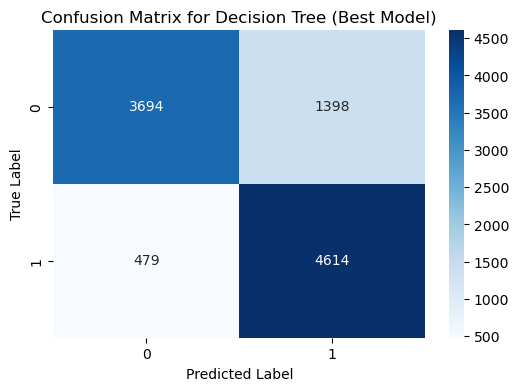


Random Forest Validation Accuracy: 0.8566
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      5092
           1       0.81      0.92      0.87      5093

    accuracy                           0.86     10185
   macro avg       0.86      0.86      0.86     10185
weighted avg       0.86      0.86      0.86     10185



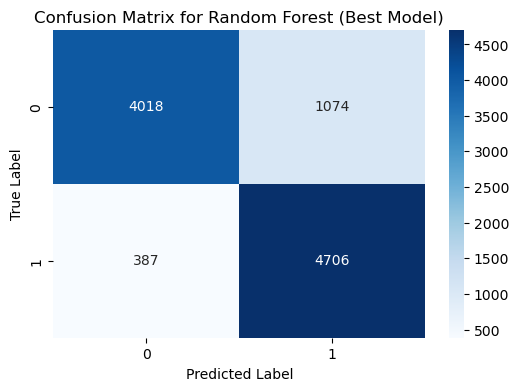


XGBoost Validation Accuracy: 0.8753
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      5092
           1       0.83      0.94      0.88      5093

    accuracy                           0.88     10185
   macro avg       0.88      0.88      0.87     10185
weighted avg       0.88      0.88      0.87     10185



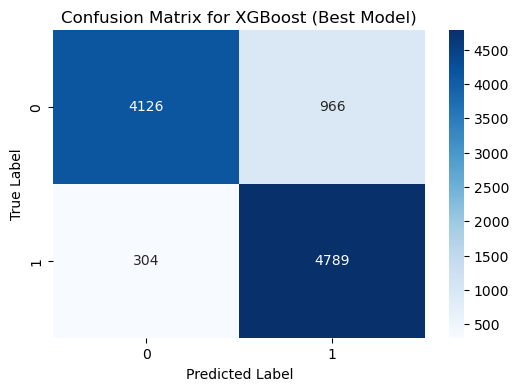


CatBoost Validation Accuracy: 0.8752
CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      5092
           1       0.83      0.94      0.88      5093

    accuracy                           0.88     10185
   macro avg       0.88      0.88      0.87     10185
weighted avg       0.88      0.88      0.87     10185



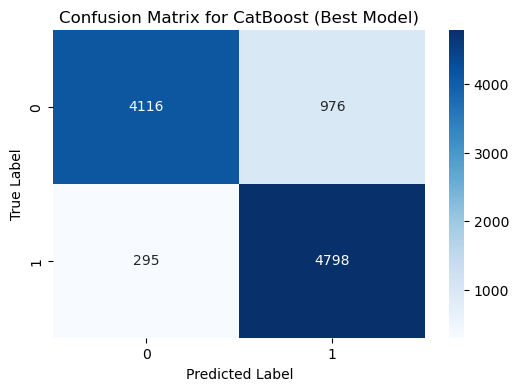


LightGBM Validation Accuracy: 0.8754
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      5092
           1       0.83      0.94      0.88      5093

    accuracy                           0.88     10185
   macro avg       0.88      0.88      0.87     10185
weighted avg       0.88      0.88      0.87     10185



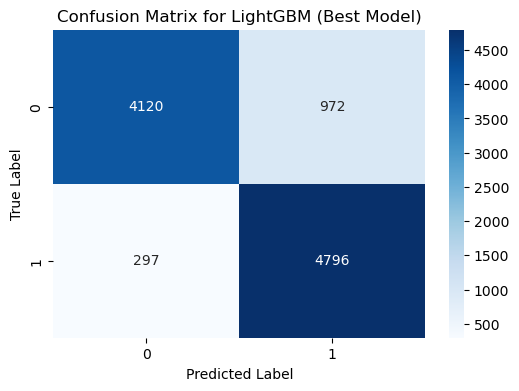

In [16]:
# Evaluate on validation set
print("Validation Set Evaluation")
best_results = {}

for name, model in best_models.items():
    try:
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        best_results[name] = accuracy
        
        print(f"\n{name} Validation Accuracy: {accuracy:.4f}")
        print(f"{name} Classification Report:")
        print(classification_report(y_val, y_pred))
        
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {name} (Best Model)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")

Test Set Evaluation
Best Model: LightGBM
Test Accuracy on 20% Test Set: 0.8700
Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      6366
           1       0.83      0.94      0.88      6365

    accuracy                           0.87     12731
   macro avg       0.88      0.87      0.87     12731
weighted avg       0.88      0.87      0.87     12731



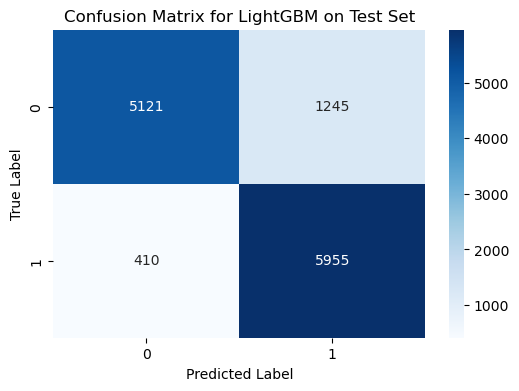


Saved best model: LightGBM with test accuracy 0.8700 to E:\Loan Model\best_loan_model.pkl


In [17]:
# best model on test set
if best_results:
    best_model_name = max(best_results, key=best_results.get)
    best_model = best_models[best_model_name]
    
    try:
        y_test_pred = best_model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        print(f"Test Set Evaluation")
        print(f"Best Model: {best_model_name}")
        print(f"Test Accuracy on 20% Test Set: {test_accuracy:.4f}")
        print(f"Test Classification Report:")
        print(classification_report(y_test, y_test_pred))
        
        # Test Confusion Matrix
        cm_test = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {best_model_name} on Test Set')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # Save best model
        joblib.dump(best_model, CLASSIFIER_PKL)
        print(f"\nSaved best model: {best_model_name} with test accuracy {test_accuracy:.4f} to {CLASSIFIER_PKL}")
        
    except Exception as e:
        print(f"Error in test evaluation: {str(e)}")
else:
    print("No models were successfully trained")

In [18]:
def train_hybrid(train_df):
    """Train hybrid model (K-Means + Regression) on approved loans."""
    print("Hybrid Model Training Started")
    
    use_cols = []
    for col in REG_NUM_COLS + CAT_COLS + [TARGET_CLASS, TARGET_REG]:
        if col in train_df.columns:
            use_cols.append(col)
    
    print(f"Available columns for hybrid model: {use_cols}")
    
    dfr = train_df.dropna(subset=use_cols).copy()
    
    # Filter approved loans (assuming 1 = approved)
    if TARGET_CLASS in dfr.columns:
        dfr = dfr[dfr[TARGET_CLASS] == 1]
    else:
        print(f"Target class column '{TARGET_CLASS}' not found")
        pass
        
    print(f"Using {len(dfr)} approved loan records for hybrid model training")
    
    return dfr

hybrid_df = train_hybrid(train_df)

Hybrid Model Training Started
Available columns for hybrid model: ['Age', 'Dependents', 'Annual_Income', 'Monthly_Income', 'Credit_Score', 'Existing_Loans', 'Total_Existing_Loan_Amount', 'Loan_Term', 'Bank_Account_History', 'Gender', 'Marital_Status', 'Education', 'Employment_Status', 'Residential_Status', 'Loan_Purpose', 'Loan_Approval_Status', 'Loan_Amount_Requested']
Using 31826 approved loan records for hybrid model training


In [19]:
# hybrid model training
if len(hybrid_df) > 0:
    available_reg_cols = [col for col in REG_NUM_COLS if col in hybrid_df.columns]
    available_cat_cols = [col for col in CAT_COLS if col in hybrid_df.columns]
    
    print(f"Regression numerical features: {available_reg_cols}")
    print(f"Regression categorical features: {available_cat_cols}")
    
    if available_reg_cols:
        Xn_raw = hybrid_df[available_reg_cols].copy()
        print(f"Target: {TARGET_REG}")

        print("Scaling numerical features for hybrid model")
        hyb_scaler = StandardScaler()
        Xn = hyb_scaler.fit_transform(Xn_raw)

        if available_cat_cols:
            Xc_raw = hybrid_df[available_cat_cols].copy().values
        else:
            Xc_raw = np.zeros((len(hybrid_df), 1)) 

        # Stage 1: K-Means
        print(f"\nApplying K-Means clustering with {N_CLUSTERS} clusters...")
        kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init="auto")
        clusters = kmeans.fit_predict(np.hstack([Xn, Xc_raw]))
        print(f"Cluster sizes: {np.bincount(clusters)}")
    else:
        print("No numerical features available for hybrid model")

Regression numerical features: ['Age', 'Dependents', 'Annual_Income', 'Monthly_Income', 'Credit_Score', 'Existing_Loans', 'Total_Existing_Loan_Amount', 'Loan_Term', 'Bank_Account_History']
Regression categorical features: ['Gender', 'Marital_Status', 'Education', 'Employment_Status', 'Residential_Status', 'Loan_Purpose']
Target: Loan_Amount_Requested
Scaling numerical features for hybrid model

Applying K-Means clustering with 3 clusters...
Cluster sizes: [ 9579 12850  9397]


In [20]:
if len(hybrid_df) > 0 and available_reg_cols:
    def one_hot(labels, k):
        m = np.zeros((len(labels), k), dtype=float)
        m[np.arange(len(labels)), labels] = 1.0
        return m

    X_reg = np.hstack([Xn, Xc_raw, one_hot(clusters, N_CLUSTERS)])
    print(f"Regression feature matrix shape: {X_reg.shape}")

    if TARGET_REG in hybrid_df.columns:
        y = hybrid_df[TARGET_REG].astype(float).copy()
    else:
        print(f"Target regression column '{TARGET_REG}' not found")
        y = np.random.randint(50000, 800000, len(hybrid_df))

    # Split data
    print("Splitting data for regression training")
    X_tr, X_te, y_tr, y_te = train_test_split(X_reg, y, test_size=0.2, random_state=RANDOM_STATE)
    print(f"Training set shape: {X_tr.shape}, Test set shape: {X_te.shape}")

    candidates = {
        "Linear": (LinearRegression(), {}),
        "RandomForest": (RandomForestRegressor(random_state=RANDOM_STATE),
                         {"n_estimators": [100, 300], "max_depth": [None, 12]}),
        "XGB": (XGBRegressor(random_state=RANDOM_STATE, objective="reg:squarederror"),
                {"n_estimators": [100, 300], "max_depth": [4, 6], "learning_rate": [0.05, 0.1]}),
        "LGBM": (LGBMRegressor(random_state=RANDOM_STATE),
                 {"n_estimators": [100, 300], "max_depth": [-1, 6], "learning_rate": [0.05, 0.1]}),
        "CatBoost": (CatBoostRegressor(random_state=RANDOM_STATE, verbose=0),
                     {"iterations": [100, 500], "depth": [6, 8], "learning_rate": [0.05, 0.1]})
    }

    best_name, best_model, best_r2 = None, None, -np.inf
    scoreboard = []

    print("Training Regression Models")

Regression feature matrix shape: (31826, 18)
Splitting data for regression training
Training set shape: (25460, 18), Test set shape: (6366, 18)
Training Regression Models



Training Linear...
Linear CV R²: 0.614

[Linear] Metrics:
R²: 0.617
MAE: 50,679.6
RMSE: 67,973.7
MAPE: 11.2%
Accuracy: 88.8%
Bin Accuracy (Top-1): 0.514
Bin Accuracy (±1): 0.922


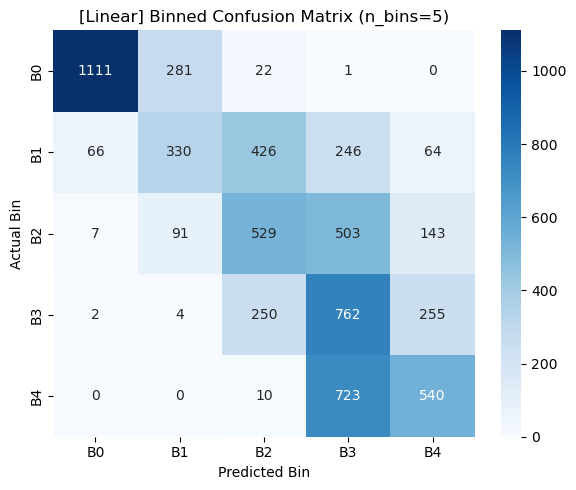


Training RandomForest...
RandomForest Best Params: {'max_depth': 12, 'n_estimators': 300}
RandomForest CV R²: 0.648

[RandomForest] Metrics:
R²: 0.652
MAE: 44,992.2
RMSE: 64,798.3
MAPE: 9.6%
Accuracy: 90.4%
Bin Accuracy (Top-1): 0.432
Bin Accuracy (±1): 0.923


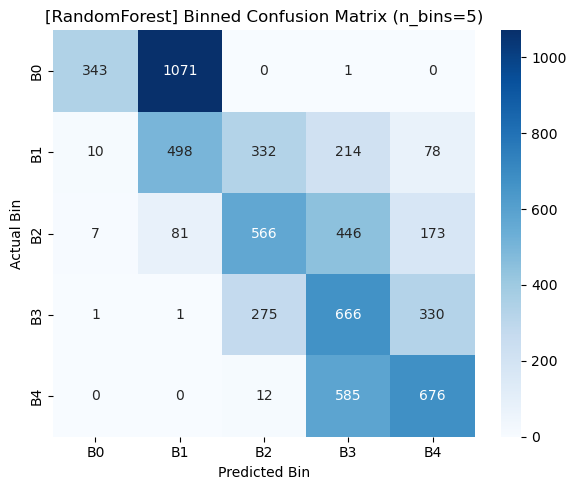


Training XGB...
XGB Best Params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
XGB CV R²: 0.654

[XGB] Metrics:
R²: 0.658
MAE: 44,908.1
RMSE: 64,223.7
MAPE: 9.6%
Accuracy: 90.4%
Bin Accuracy (Top-1): 0.448
Bin Accuracy (±1): 0.924


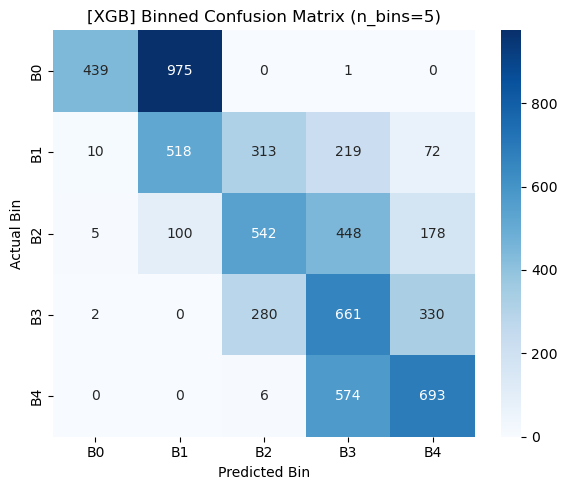


Training LGBM...
LGBM Best Params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100}
LGBM CV R²: 0.652

[LGBM] Metrics:
R²: 0.655
MAE: 44,923.1
RMSE: 64,461.1
MAPE: 9.6%
Accuracy: 90.4%
Bin Accuracy (Top-1): 0.431
Bin Accuracy (±1): 0.926


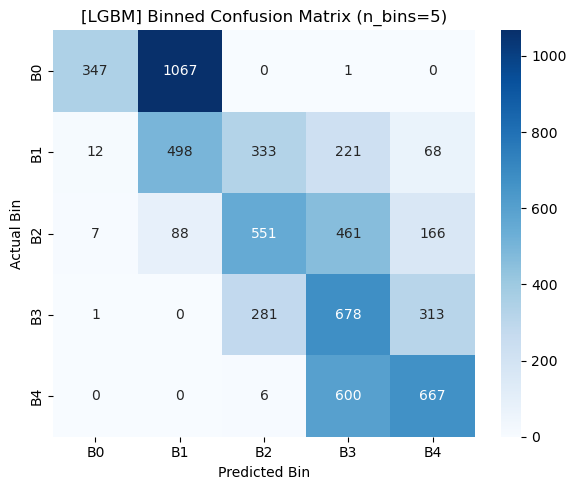


Training CatBoost...
CatBoost Best Params: {'depth': 6, 'iterations': 100, 'learning_rate': 0.05}
CatBoost CV R²: 0.652

[CatBoost] Metrics:
R²: 0.655
MAE: 45,608.4
RMSE: 64,493.5
MAPE: 9.8%
Accuracy: 90.2%
Bin Accuracy (Top-1): 0.499
Bin Accuracy (±1): 0.918


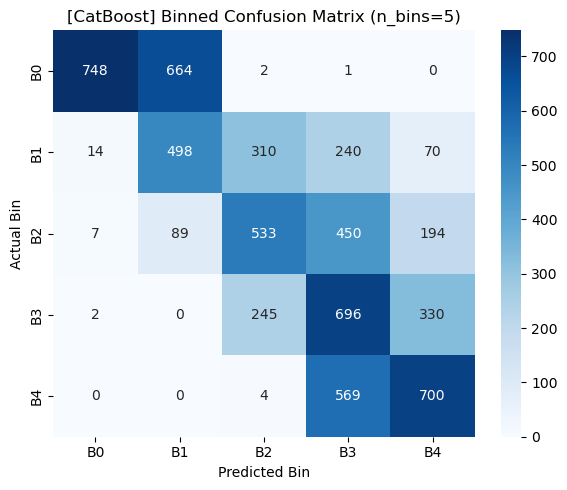

In [21]:
# regression model training
if 'candidates' in locals():
    for name, (reg, grid) in candidates.items():
        print(f"\nTraining {name}...")
        try:
            if grid:
                cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
                gs = GridSearchCV(reg, grid, cv=cv, scoring="r2", n_jobs=-1)
                gs.fit(X_tr, y_tr)
                model = gs.best_estimator_
                cv_r2 = gs.cv_results_['mean_test_score'][gs.best_index_]
                print(f"{name} Best Params: {gs.best_params_}")
            else:
                model = reg.fit(X_tr, y_tr)
                cv_r2 = float(np.mean(cross_val_score(model, X_tr, y_tr, cv=3, scoring="r2")))
            
            print(f"{name} CV R²: {cv_r2:.3f}")

            y_hat = model.predict(X_te)
            metrics = eval_reg_with_bins(y_te, y_hat, n_bins=N_BINS, title=f"[{name}] ")

            scoreboard.append({
                "Model": name,
                "CV R²": cv_r2,
                "Test R²": metrics["r2"],
                "MAE": metrics["mae"],
                "RMSE": metrics["rmse"],
                "BinAcc (Top-1)": metrics["bin_acc"],
                "BinAcc (±1)": metrics["bin_acc_pm1"],
                "Accuracy %": metrics["accuracy_pct"]
            })

            if metrics["r2"] > best_r2:
                best_r2 = metrics["r2"]
                best_name = name
                best_model = model
                
        except Exception as e:
            print(f"Error training {name}: {str(e)}")

In [22]:
# Regression model summary code
if scoreboard:
    summary_df = pd.DataFrame(scoreboard).sort_values(by="Test R²", ascending=False)
    fmt = {
        "CV R²": "{:.3f}".format, 
        "Test R²": "{:.3f}".format,
        "MAE": lambda x: f"{x:,.1f}", 
        "RMSE": lambda x: f"{x:,.1f}",
        "BinAcc (Top-1)": lambda x: f"{x:.3f} ({x*100:.0f}%)",
        "BinAcc (±1)": lambda x: f"{x:.3f} ({x*100:.0f}%)",
        "Accuracy %": lambda x: f"{x:.1f}%"
    }
    
    # evaluation summary
    print("\n" + "="*80)
    print("REGRESSION MODEL EVALUATION SUMMARY")
    print("="*80)
    print(summary_df.to_string(index=False, formatters=fmt))
    
    # Save summary CSV
    summary_df.to_csv(EVAL_CSV, index=False)
    print(f"\n[HYBRID] Saved summary CSV -> {EVAL_CSV}")
    
    # Show selected model
    print(f"[HYBRID] Selected: {best_name} (Test R²={best_r2:.3f})")
    
    # Save hybrid model
    hybrid_bundle = {
        "scaler": hyb_scaler,
        "kmeans": kmeans,
        "n_clusters": N_CLUSTERS,
        "reg_model": best_model,
        "reg_num_cols": available_reg_cols,
        "cat_cols": available_cat_cols,
        "enc_maps": ENCODERS
    }
    joblib.dump(hybrid_bundle, HYBRID_PKL)
    print(f"[HYBRID] Saved -> {HYBRID_PKL}")
else:
    print("No regression models were successfully trained")


REGRESSION MODEL EVALUATION SUMMARY
       Model CV R² Test R²      MAE     RMSE BinAcc (Top-1) BinAcc (±1) Accuracy %
         XGB 0.654   0.658 44,908.1 64,223.7    0.448 (45%) 0.924 (92%)      90.4%
        LGBM 0.652   0.655 44,923.1 64,461.1    0.431 (43%) 0.926 (93%)      90.4%
    CatBoost 0.652   0.655 45,608.4 64,493.5    0.499 (50%) 0.918 (92%)      90.2%
RandomForest 0.648   0.652 44,992.2 64,798.3    0.432 (43%) 0.923 (92%)      90.4%
      Linear 0.614   0.617 50,679.6 67,973.7    0.514 (51%) 0.922 (92%)      88.8%

[HYBRID] Saved summary CSV -> E:\Loan Model\Regression_Model_Evaluation_Summary.csv
[HYBRID] Selected: XGB (Test R²=0.658)
[HYBRID] Saved -> E:\Loan Model\hybrid_pipeline.pkl


In [26]:
# User inputs
def assess_and_suggest(user_input, cap_at_requested=True, round_to=1000):
    try:
        clf_model = joblib.load(CLASSIFIER_PKL)
        clf_scaler = joblib.load(SCALER_PKL)
        print(f"Loaded classifier from {CLASSIFIER_PKL}")
        print(f"Loaded scaler from {SCALER_PKL}")
    except FileNotFoundError as e:
        print(f"Model files not found: {e}")
        return {"error": "Models not found"}

    # Prepare classifier input
    clf_feature_order = ['Gender', 'Age', 'Marital_Status', 'Dependents', 'Education', 'Employment_Status',
                        'Residential_Status', 'Annual_Income', 'Monthly_Income', 'Credit_Score',
                        'Existing_Loans', 'Total_Existing_Loan_Amount', 'Loan_Amount_Requested',
                        'Loan_Term', 'Loan_Purpose', 'Bank_Account_History']
    
    Xclf_raw = pd.DataFrame([user_input], columns=clf_feature_order)

    # Encode and scale
    print("\nPreprocessing user input")
    Xclf = Xclf_raw.copy()
    for col in CAT_COLS:
        if col in Xclf.columns:
            Xclf[col] = Xclf[col].map(ENCODERS[col])
            print(f"Encoded {col}: {Xclf[col].iloc[0]}")
    
    available_num_cols = [col for col in NUMERICAL_COLS if col in Xclf.columns]
    Xclf[available_num_cols] = clf_scaler.transform(Xclf[available_num_cols])
    print("Scaled numerical features")

    # Display user input
    print("\nUser Input Data:")
    formatters = {
        'Age': '{:.0f}'.format,
        'Dependents': '{:.0f}'.format,
        'Annual_Income': '{:.0f}'.format,
        'Monthly_Income': '{:.0f}'.format,
        'Credit_Score': '{:.0f}'.format,
        'Existing_Loans': '{:.0f}'.format,
        'Total_Existing_Loan_Amount': '{:.0f}'.format,
        'Loan_Amount_Requested': '{:.0f}'.format,
        'Loan_Term': '{:.0f}'.format,
        'Bank_Account_History': '{:.0f}'.format
    }
    display_formatters = {k: v for k, v in formatters.items() if k in Xclf_raw.columns}
    print(Xclf_raw.to_string(index=False, formatters=display_formatters))

    # Predict eligibility with original amount
    print("\nPredicting loan eligibility with original amount...")
    y_pred = clf_model.predict(Xclf)[0]
    proba = clf_model.predict_proba(Xclf)[0, 1] if hasattr(clf_model, 'predict_proba') else None
    eligibility = 'Eligible' if y_pred == 1 else 'Not Eligible'
    print(f"Initial Eligibility Prediction: {eligibility}")
    print(f"Initial Confidence: {proba:.2%}" if proba else "Initial Confidence: N/A")

    result = {
        "eligibility": eligibility,
        "confidence": float(proba) if proba is not None else None,
        "suggested_amount": None,
        "cluster": None,
        "regression_model": None,
        "final_eligibility": eligibility,
        "final_confidence": float(proba) if proba is not None else None,
        "approved_amount": user_input['Loan_Amount_Requested'] if y_pred == 1 else None
    }

    # If not eligible, suggest amount
    if y_pred == 0:
        print("\nLoan not eligible with original amount, suggesting alternative amount")
        try:
            hyb = joblib.load(HYBRID_PKL)
            print(f"Loaded hybrid model from {HYBRID_PKL}")
            reg_cols = hyb["reg_num_cols"] + hyb["cat_cols"]
            Xreg_raw = pd.DataFrame([{col: user_input.get(col) for col in reg_cols}])
            
            for col in hyb["cat_cols"]:
                if col in hyb["enc_maps"]:
                    Xreg_raw[col] = Xreg_raw[col].map(hyb["enc_maps"][col])
                    print(f"Encoded {col} for regression: {Xreg_raw[col].iloc[0]}")

            # Stage-1: Cluster
            Xn = hyb["scaler"].transform(Xreg_raw[hyb["reg_num_cols"]])
            Xc = Xreg_raw[hyb["cat_cols"]].values
            X_for_cluster = np.hstack([Xn, Xc])
            cluster_id = int(hyb["kmeans"].predict(X_for_cluster)[0])
            print(f"Assigned to cluster: {cluster_id}")

            # Stage-2: Regression
            onehot = np.zeros((1, hyb["n_clusters"]), dtype=float)
            onehot[0, cluster_id] = 1.0
            X_reg_in = np.hstack([Xn, Xc, onehot])
            pred_amount = float(hyb["reg_model"].predict(X_reg_in)[0])
            print(f"Raw predicted amount: {pred_amount:,.2f}")

            # Cap and round
            requested = float(user_input.get('Loan_Amount_Requested', pred_amount))
            if cap_at_requested:
                pred_amount = min(pred_amount, requested)
                print(f"Capped at requested amount: {pred_amount:,.2f}")
            if round_to and round_to > 0:
                pred_amount = round(pred_amount / round_to) * round_to
                print(f"Rounded to nearest {round_to:,}: {pred_amount:,.2f}")

            result["suggested_amount"] = pred_amount
            result["cluster"] = cluster_id
            result["regression_model"] = type(hyb["reg_model"]).__name__

            # Re-check eligibility with suggested amount
            print("\nRe-checking eligibility with suggested amount")
            updated_input = user_input.copy()
            updated_input['Loan_Amount_Requested'] = pred_amount
            Xclf_raw_updated = pd.DataFrame([updated_input], columns=clf_feature_order)

            Xclf_updated = Xclf_raw_updated.copy()
            for col in CAT_COLS:
                if col in Xclf_updated.columns:
                    Xclf_updated[col] = Xclf_updated[col].map(ENCODERS[col])
            Xclf_updated[available_num_cols] = clf_scaler.transform(Xclf_updated[available_num_cols])
            print("Updated and scaled input for re-check")

            y_pred_updated = clf_model.predict(Xclf_updated)[0]
            proba_updated = clf_model.predict_proba(Xclf_updated)[0, 1] if hasattr(clf_model, 'predict_proba') else None
            final_eligibility = 'Eligible' if y_pred_updated == 1 else 'Not Eligible'
            print(f"Final Eligibility Prediction: {final_eligibility}")
            print(f"Final Confidence: {proba_updated:.2%}" if proba_updated else "Final Confidence: N/A")

            result["final_eligibility"] = final_eligibility
            result["final_confidence"] = float(proba_updated) if proba_updated is not None else None
            result["approved_amount"] = pred_amount if y_pred_updated == 1 else None

        except Exception as e:
            print(f"Error in hybrid model processing: {e}")

    return result

# Example user input
user_input = {
    'Gender': 'Male',
    'Age': 35,
    'Marital_Status': 'Single',
    'Dependents': 2,
    'Education': 'Graduate',
    'Employment_Status': 'Employed',
    'Residential_Status': 'Own',
    'Annual_Income': 600000,
    'Monthly_Income': 100000,
    'Credit_Score': 712,
    'Existing_Loans': 1,
    'Total_Existing_Loan_Amount': 31523,
    'Loan_Amount_Requested': 200000, 
    'Loan_Term': 60,
    'Loan_Purpose': 'Small Business Start-up',
    'Bank_Account_History': 2
}

# Perform joint inference
print("\Performing Joint Inference")
result = assess_and_suggest(user_input)

# Display results
print("\Loan Assessment Result")
print(f"Initial Eligibility: {result['eligibility']}")
print(f"Initial Confidence: {result['confidence']:.2%}" if result['confidence'] else "Initial Confidence: N/A")

if result['suggested_amount'] is not None:
    print(f"Suggested Loan Amount: ${result['suggested_amount']:,.0f}")
    print(f"Cluster: {result['cluster']}")
    print(f"Regression Model: {result['regression_model']}")
    print(f"Final Eligibility (with suggested amount): {result['final_eligibility']}")
    print(f"Final Confidence: {result['final_confidence']:.2%}" if result['final_confidence'] else "Final Confidence: N/A")

print(f"Approved Amount: {result['approved_amount']:,.0f}" if result['approved_amount'] is not None else "Approved Amount: None")

# Example 2
eligible_user_input = {
    'Gender': 'Female',
    'Age': 32,
    'Marital_Status': 'Married',
    'Dependents': 1,
    'Education': 'Graduate',
    'Employment_Status': 'Employed',
    'Residential_Status': 'Own',
    'Annual_Income': 750000,
    'Monthly_Income': 78000,
    'Credit_Score': 660,  
    'Existing_Loans': 0,
    'Total_Existing_Loan_Amount': 0,
    'Loan_Amount_Requested': 800000,  
    'Loan_Term': 24,
    'Loan_Purpose': 'Equipment Purchase',
    'Bank_Account_History': 5
}

print("\n\n" + "="*60)
print("EXAMPLE 2: ELIGIBLE USER")
print("="*60)

result2 = assess_and_suggest(eligible_user_input)

print("\n=== Loan Assessment Result (Eligible User) ===")
print(f"Initial Eligibility: {result2['eligibility']}")
print(f"Initial Confidence: {result2['confidence']:.2%}" if result2['confidence'] else "Initial Confidence: N/A")
print(f"Approved Amount: {result2['approved_amount']:,.0f}" if result2['approved_amount'] is not None else "Approved Amount: None")

\Performing Joint Inference
Loaded classifier from E:\Loan Model\best_loan_model.pkl
Loaded scaler from E:\Loan Model\scaler.pkl

Preprocessing user input
Encoded Gender: 0
Encoded Marital_Status: 1
Encoded Education: 1
Encoded Employment_Status: 1
Encoded Residential_Status: 1
Encoded Loan_Purpose: 2
Scaled numerical features

User Input Data:
Gender Age Marital_Status Dependents Education Employment_Status Residential_Status Annual_Income Monthly_Income Credit_Score Existing_Loans Total_Existing_Loan_Amount Loan_Amount_Requested Loan_Term            Loan_Purpose Bank_Account_History
  Male  35         Single          2  Graduate          Employed                Own        600000         100000          712              1                      31523                200000        60 Small Business Start-up                    2

Predicting loan eligibility with original amount...
Initial Eligibility Prediction: Eligible
Initial Confidence: 62.88%
\Loan Assessment Result
Initial Eligibilit